# Pokus pouzit jine modely pro poravnani s jinymi

In [68]:
from typing import List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, MaxPooling1D, Flatten,  Activation
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os
os.chdir('C:/Users/Home/Desktop/vyučovaní/Programovani/1 Letni semestr 2 rocnik/PPM2/3 uloha')

## MODEL CONV 1D

In [69]:
# def priprava_souboru_do_csv() -> None:
#     df_diagnostic = pd.read_excel("scr/Diagnostics.xlsx")
#     diagnostic_naz_sloupcu = df_diagnostic.keys()

#     SB_a_AFIB_nazvy_souboru = []

#     for i in range(len(df_diagnostic[diagnostic_naz_sloupcu[0]][:])):
#         if df_diagnostic[diagnostic_naz_sloupcu[1]][i] == "SR" or  df_diagnostic[diagnostic_naz_sloupcu[1]][i] == "AFIB":
#             pacient = [ df_diagnostic[diagnostic_naz_sloupcu[0]][i], df_diagnostic[diagnostic_naz_sloupcu[1]][i] ]
#             SB_a_AFIB_nazvy_souboru.append(pacient)
    
#     SB_a_AFIB_nazvy_souboru = pd.DataFrame(SB_a_AFIB_nazvy_souboru)
#     SB_a_AFIB_nazvy_souboru.to_csv("SB_a_AFIB_nazvy_souboru.csv")

# priprava_souboru_do_csv()

In [70]:
def stahovani_ekg_signalu_pacientu(nazev_souboru: str)-> Tuple[List[pd.DataFrame], List[int]]:
    SB_a_AFIB_nazvy_souboru = pd.read_csv(f"{nazev_souboru}.csv")
    X_data = []
    y_data = []
    for i in range(len(SB_a_AFIB_nazvy_souboru)//3):
        nemoc = SB_a_AFIB_nazvy_souboru["1"][i]
        soubor = SB_a_AFIB_nazvy_souboru["0"][i]
        match nemoc:
            case "AFIB":
                y_data.append(0)
            case "SR":
                y_data.append(1)
        signal_pacienta = pd.read_csv(f"data_sigmalu/ECGDataDenoised/{soubor}.csv",usecols=[0], names = ["a"], nrows= 1000)
        X_data.append(signal_pacienta)
        
    return X_data, y_data

In [71]:
# SB_a_AFIB_nazvy_souboru = pd.read_csv("SB_a_AFIB_nazvy_souboru.csv")
# soubor = SB_a_AFIB_nazvy_souboru["0"][0]
# signal_pacienta = pd.read_csv(f"data_sigmalu/ECGDataDenoised/{soubor}.csv",usecols=[0], names = ["a"], nrows= 1000)


In [72]:
# plt.figure(figsize = (20,5))
# plt.plot(signal_pacienta)

In [73]:
X_data, y_data = stahovani_ekg_signalu_pacientu("SB_a_AFIB_nazvy_souboru")

In [74]:
def predzpracovani_dat_signalu(X_data, y_data) -> Tuple[List[int], List[int], List[int], List[int], Tuple[int,int,int]]:
    X_data = np.array(X_data)
    shape_data = X_data.shape 
    X_data = X_data.reshape(shape_data[0], shape_data[1])
    y_data = np.array(y_data)
    # y_data = y_data.reshape(y_data.shape[0],1)
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # data_scaled = scaler.fit_transform(X_data)
    
    x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)         #(data_scaled, y_data, test_size=0.2)
    
    return x_train, x_test, y_train, y_test, shape_data 

In [75]:
x_train, x_test, y_train, y_test, shape_data = predzpracovani_dat_signalu(X_data, y_data)
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f'X_data.shape {shape_data}')

x_test: (241, 1000), y_test: (241,)
x_train: (961, 1000), y_train: (961,)
X_data.shape (1202, 1000, 1)


prumer = sum_hodnot/ pocet hodnot

rozptyl = ((x1 - prumer)^2 +...+ (xi - prumer)^2) pocet hodnot

smerodatna odchylka = sqrt(rozptyl)

normalizace kazde hodnoty:

x1 = (x1 - prumer)/ smerodatna odchylka ...xi = ...

po normalizace prumer se blizi k 0, smerodatna odchylka k 1

In [251]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, MaxPooling1D, Flatten, BatchNormalization

def vytvoreni_modelu(shape_data):
    
    model = Sequential()
    model.add(Input(shape=(shape_data[1], 1))) # [batch_size, 1000, 1]

    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')) # Vystup: [batch_size, 1000, 64]
    model.add(BatchNormalization()) # Normalizuje hodnoty v kazde z 64 feature map.
    model.add(MaxPooling1D(pool_size=5, padding='same')) # Sniz poc dat, vybira nejvys hodnotu z každého okna dat pool_size, [batch_size, 200, 64]
    model.add(Dropout(0.1))

    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')) # [batch_size, 200, 64] nove future mapy
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5, padding='same')) # [batch_size, 40, 64]
    model.add(Dropout(0.3))

    model.add(Flatten()) # [batch_size, 40 * 64]
    
    model.add(Dense(units=80, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=1, activation='sigmoid'))
    
    return model


In [252]:
def compilace_uceni(model,x_train, x_test, y_train, y_test ):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint(filepath="model_conv_1D.keras", save_best_only=True) # Behem treninku 999

    history = model.fit(x_train, y_train,
                        epochs=20,  
                        batch_size=32, # davkovani v uceni 
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint],
                        verbose=1)
    
    return history, model

In [253]:
def zobrazit_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    # plt.savefig(plt.savefig(f'vysledek_1D_conv.png'))
    plt.show()

In [254]:
def zobrazit_loss(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    # plt.legend(loc='lower right')
    # plt.savefig(plt.savefig(f'vysledek_1D_conv.png'))
    plt.show()

In [255]:
model = vytvoreni_modelu(shape_data)
history, model = compilace_uceni(model,x_train, x_test, y_train, y_test)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.4994 - loss: 1.1857 - val_accuracy: 0.5851 - val_loss: 0.8413
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7248 - loss: 0.5581 - val_accuracy: 0.6929 - val_loss: 0.7241
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8348 - loss: 0.3967 - val_accuracy: 0.7220 - val_loss: 0.6532
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8601 - loss: 0.3559 - val_accuracy: 0.7386 - val_loss: 0.6630
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8748 - loss: 0.3192 - val_accuracy: 0.7676 - val_loss: 0.6242
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8812 - loss: 0.2937 - val_accuracy: 0.7676 - val_loss: 0.6397
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8916 - loss: 0.2591 - val_accuracy: 0.7925 - val_loss: 0.5504
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9088 - loss: 0.2423 - val_accuracy: 0.7842 - v

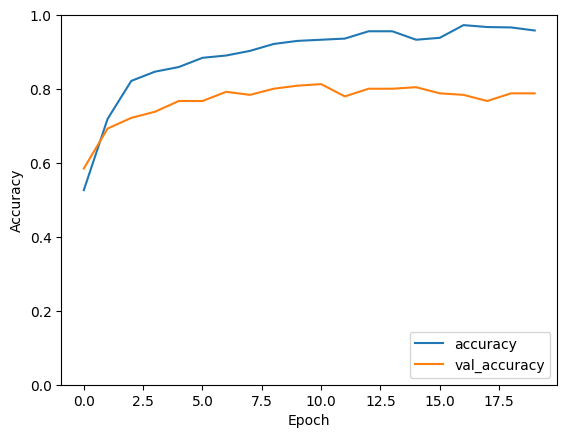

In [256]:
zobrazit_accuracy(history)
# test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

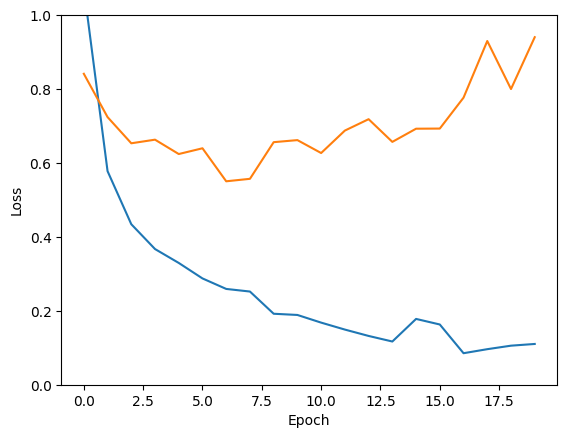

In [257]:
zobrazit_loss(history)